<a href="https://colab.research.google.com/github/Poirazi-Lab/dendrify/blob/main/paper_figures/Fig5_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
> *In this interactive Python notebook, we present and briefly discuss the code needed to replicate the model and the results shown in Figure 5 of the manuscript. In this example our main goal is to illustrate that:*
>
> - *The simplified CA1 model we presented, can reproduce complex pathway interaction rules that rely on dendritic VGICs, in addition to essential electrophysiological properties of real neurons (Fig. 4).*
>
>
> **Important:** *since Figure 5 requires in total 242 different simulations, it is impractical and time-concuming to perform all of them in this notebook. Therefore, to recreate panels d-f we will utilise existing data that will be downloaded automatically from an [online repository (fig7-data.zip)](https://github.com/Poirazi-Lab/dendrify/blob/main/paper_figures/other/fig7-data.zip).*
>
> <hr>
>
> *__Note__: In case you are unfamiliar with how Python notebooks work and you would like to run or rerun the entire code, simply select one of the options bellow:*
>
> - **Runtime ➝ Run all**
> - **Runtime ➝ Restart and run all**
>
> *located on the top menu and wait a few seconds until all cells finish running.*
> <hr>
>
> *All source code of the current Dendrify version is available on* [GitHub](https://github.com/Poirazi-Lab/dendrify)

## Setup

In [1]:
#@title Install dependencies and download simulated data (might take a few seconds)
# import os
# if 'dendrify' in os.getcwd():
#     pass
# else:
#     !git clone https://github.com/Poirazi-Lab/dendrify.git --quiet
#     os.chdir('dendrify/paper_figures')
# !pip install brian2 --quiet
# !pip install dendrify --quiet
# !git lfs pull --include=other/fig7-data.zip

In [2]:
#@title Imports and settings
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt,
                          Hz, msiemens) # Generally a better practise than * imports
from dendrify import Soma, Dendrite, NeuronModel
from zipfile import ZipFile
import pickle as p
import seaborn as sns
import matplotlib.patches as mpatches
import time


b.prefs.codegen.target = 'numpy' # Improves performance significantly here

# @title Figure settings
graphite = "#4B4E53"
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
notred = '#aa0044ff'
dsblue = '#0BA8E6'
light_gray = "#b5b5b5"
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'grid.linestyle': ":",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, green, orange, notred])
          }

b.rcParams.update(params)

## Create model
>*Biological CA1 PCs are more likely to be activated when input from the EC on their distal tuft is paired with coincident CA3 input on more proximal dendritic branches. Due to strong dendritic attenuation, distal synaptic input generally has a negligible effect on the soma. However, combining EC and (moderate) CA3 input results in more reliable dSpike initiation and propagation, facilitating axonal action-potential output [(Jarsky et al)](https://www.nature.com/articles/nn1599).*
>
>*To test if our reduced model captures the described phenomenon, we will try to replicate the experiments of Jarksy et al, using a pool of 10000 neurons. Each neuron represents a repetition of the same experiment with independent Poisson-distributed inputs of the same average frequency. (For more information see: __Example 4: Pathway interaction in CA1 model neurons__ in the manuscript.*
>
><br>
>
><p align="center">
    <img src="https://github.com/Poirazi-Lab/dendrify/blob/main/paper_figures/graphics/ca1_coincidence.png?raw=true" alt="model" width="35%">
></p>
>
><br>
>
> *NOTE: The following code was initially written in a way that allows running multiple simulations in parallel using a separate submission script.
Here, we will run a single simulation for each experiment (dSpikes ON/OFF)
using the parameters shown bellow. At the end of the notebook we also provide
the submission script for anyone interested to check it.*

In [3]:
SEED = 2021
INPUT_EC = True
INPUT_CA3 = True
DSPIKES = True
FREQ_EC = 82*Hz
FREQ_CA3 = 120*Hz
N_PYR = 10000
T_SIM = 500*ms
# Custom conductance-based adaptive I&F equations and parameters
eqsCAdIF = '''
dV{0}/dt =  (gL{0}*(EL{0}-V{0}) + Ia{0} + I{0}) / C{0} :volt
Ia{0} = gA * (EA-V{0}) :amp
dgA/dt = (gAmax * (abs(V{0}-VA)) / mV - gA) / tauA :siemens
I{0} = I_ext{0}  :amp
I_ext{0}  :amp
'''
paramsCAdIF = {
    "EA": -65 * mV,  # reversal potential of Ia
    "VA": -65 * mV,  # subthreshold adaptation activation voltage
    "tauA": 45 * ms,  # time constant of adaptation
    "gAmax": 0.15 * nS,  # maximal subthreshold adaptation conductance
    "delta_gA": 21*nS,  # spike-triggered adaptation
    "Vth": -47.5 * mV,  # AP threshold -47.5
    "Vr1": 37.5 * mV,  # 1st voltage seset after AP
}
# Set basic parameters using values from experimental data
paramsExp = {
    'alpha': 0.087,
    'beta':  3.57,
    'gamma': 10,
    'Mg': 1,
    'E_NMDA': 0.35*mV,
    "E_Na": 50 * mV,
    "E_K": -90 * mV
}
gNa = 10*msiemens*cm**-2
gKn = gNa/2.5
Vdspike = -42.5*mV
# Create compartments
soma = Soma('soma', model=eqsCAdIF, length=30*um, diameter=20*um)
proximal = Dendrite('prox', length=100*um, diameter=2*um)
oblique_1 = Dendrite('ob1', length=100*um, diameter=1*um)
oblique_2 = Dendrite('ob2', length=100*um, diameter=1*um )
medial = Dendrite('med', length=150*um, diameter=1.25*um)
distal_1 = Dendrite('dist1', length=150*um, diameter=0.8*um )
distal_2 = Dendrite('dist2', length=150*um, diameter=0.8*um)
basal_1 = Dendrite('bas1', length=150*um, diameter=0.8*um)
basal_2 = Dendrite('bas2', length=150*um, diameter=0.8*um)
# Dendritic spikes properties
if DSPIKES:
    proximal.dspikes('Na', threshold=Vdspike,
                     g_rise=gNa*proximal.area,
                     g_fall=gKn*proximal.area)
    oblique_1.dspikes('Na', threshold=Vdspike,
                      g_rise=gNa*oblique_1.area,
                      g_fall=gKn*oblique_1.area)
    oblique_2.dspikes('Na', threshold=Vdspike,
                      g_rise=gNa*oblique_1.area,
                      g_fall=gKn*oblique_1.area)
    medial.dspikes('Na', threshold=Vdspike,
                   g_rise=gNa*medial.area,
                   g_fall=gKn*medial.area)
    distal_1.dspikes('Na', threshold=Vdspike,
                     g_rise=gNa*distal_1.area,
                     g_fall=gKn*distal_1.area)
    distal_2.dspikes('Na', threshold=Vdspike,
                     g_rise=gNa*distal_1.area,
                     g_fall=gKn*distal_1.area)
    basal_1.dspikes('Na', threshold=Vdspike,
                    g_rise=gNa*basal_1.area,
                    g_fall=gKn*basal_1.area)
    basal_2.dspikes('Na', threshold=Vdspike,
                    g_rise=gNa*basal_2.area,
                    g_fall=gKn*basal_2.area)
# Synaptic properties
if INPUT_CA3:
    oblique_1.synapse("AMPA", pre='ca3', g=0.6*nS, t_decay=2.5*ms)
    oblique_1.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
    oblique_2.synapse("AMPA", pre='ca3', g=0.6*nS, t_decay=2.5*ms)
    oblique_2.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
    medial.synapse("AMPA", pre='ca3', g=0.81*nS, t_decay=2.5*ms)
    medial.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
if INPUT_EC:
    distal_1.synapse("AMPA", pre='ec', g=0.81*nS, t_decay=2.5*ms)
    distal_1.synapse("NMDA", pre='ec', g=0.81*nS, t_decay=50*ms)
    distal_2.synapse("AMPA", pre='ec', g=0.81*nS, t_decay=2.5*ms)
    distal_2.synapse("NMDA", pre='ec', g=0.81*nS, t_decay=50*ms)
# Merge all compartments into a single model
edges = [(soma, basal_1, 3.8*nS), (soma, basal_2, 3.8*nS),
         (soma, proximal, 22*nS), (proximal, oblique_1),
         (proximal, oblique_2), (proximal, medial), 
         (medial, distal_1), (medial, distal_2)]

pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                        r_axial=120*ohm*cm, v_rest=-65*mV,
                        scale_factor=2.9, spine_factor=1.5)
# Include model params
pyr_model.add_params(paramsCAdIF)
pyr_model.add_params(paramsExp)
pyr_model.dspike_properties('Na', tau_rise=0.5*ms, tau_fall=1.2*ms,
                            refractory=4.2*ms, offset_fall=0.6*ms)
#-------------------------dendrify workflow ends here--------------------------#

## Create NeuronGroup

In [4]:
b.start_scope()  # allows running separate simulations in the same notebook
pyr_group = b.NeuronGroup(N_PYR, threshold='V_soma > Vth', refractory=4*ms,
                          reset='V_soma = Vr1; gA += delta_gA', method='euler',
                          model=pyr_model.equations, events=pyr_model.events,
                          namespace=pyr_model.parameters)
# Link pyramidal model to the neurongroup
pyr_model.link(pyr_group)
# Second reset trick
second_reset = b.Synapses(pyr_group, pyr_group, on_pre='V_soma=-53 * mV',
                          delay=0.8*ms)
second_reset.connect(j='i')
# Set monitor for somatic spikes
S = b.SpikeMonitor(pyr_group)

## Create Poisson inputs

In [5]:
if INPUT_EC:
    b.seed(SEED)
    I_ec1 = b.PoissonGroup(N_PYR, FREQ_EC)
    S_ec1 = b.Synapses(I_ec1, pyr_group,
                       on_pre='s_AMPA_ec_dist1 += 1.0; s_NMDA_ec_dist1 += 1.0')
    S_ec1.connect('i==j')
    I_ec2 = b.PoissonGroup(N_PYR, FREQ_EC)
    S_ec2 = b.Synapses(I_ec2, pyr_group,
                       on_pre='s_AMPA_ec_dist2 += 1.0; s_NMDA_ec_dist2 += 1.0')
    S_ec2.connect('i==j')
if INPUT_CA3:
    b.seed(SEED)
    I_ca3_1 = b.PoissonGroup(N_PYR, FREQ_CA3)
    S_ca3_1 = b.Synapses(I_ca3_1, pyr_group,
                         on_pre='s_AMPA_ca3_ob1 += 1.0; s_NMDA_ca3_ob1 += 1.0')
    S_ca3_1.connect('i==j')
    I_ca3_2 = b.PoissonGroup(N_PYR, FREQ_CA3)
    S_ca3_2 = b.Synapses(I_ca3_2, pyr_group,
                         on_pre='s_AMPA_ca3_ob2 += 1.0; s_NMDA_ca3_ob2 += 1.0')
    S_ca3_2.connect('i==j')
    I_ca3_3 = b.PoissonGroup(N_PYR, FREQ_CA3)
    S_ca3_3 = b.Synapses(I_ca3_3, pyr_group,
                         on_pre='s_AMPA_ca3_med += 1.0; s_NMDA_ca3_med += 1.0')
    S_ca3_3.connect('i==j')

## Run simulation (dspikes ON)
> *Expected time of completion: ~25 seconds but this is inconsistent in google colab :(*

In [6]:
t1 = time.time()
print(f"Simulation started.")
b.run(T_SIM)
t2 = time.time()
print(f"Simulation ended. \n(Time: {t2-t1:.2f} s)")
spikes_ON = S.count

Simulation started.
Simulation ended. 
(Time: 21.65 s)


## Repeat previous process and run simulation (dSpikes OFF)

In [7]:
# @title  Create model
SEED = 2021
INPUT_EC = True
INPUT_CA3 = True
DSPIKES = False
FREQ_EC = 82*Hz
FREQ_CA3 = 120*Hz
N_PYR = 10000
T_SIM = 500*ms
# Custom conductance-based adaptive I&F equations and parameters
eqsCAdIF = '''
dV{0}/dt =  (gL{0}*(EL{0}-V{0}) + Ia{0} + I{0}) / C{0} :volt
Ia{0} = gA * (EA-V{0}) :amp
dgA/dt = (gAmax * (abs(V{0}-VA)) / mV - gA) / tauA :siemens
I{0} = I_ext{0}  :amp
I_ext{0}  :amp
'''
paramsCAdIF = {
    "EA": -65 * mV,  # reversal potential of Ia
    "VA": -65 * mV,  # subthreshold adaptation activation voltage
    "tauA": 45 * ms,  # time constant of adaptation
    "gAmax": 0.15 * nS,  # maximal subthreshold adaptation conductance
    "delta_gA": 21*nS,  # spike-triggered adaptation
    "Vth": -47.5 * mV,  # AP threshold -47.5
    "Vr1": 37.5 * mV}  # 1st voltage seset after AP

# Set basic parameters using values from experimental data
paramsExp = {
    'alpha': 0.087,
    'beta':  3.57,
    'gamma': 10,
    'Mg': 1,
    'E_NMDA': 0.35*mV,
    "E_Na": 50 * mV,
    "E_K": -90 * mV
}
gNa = 10*msiemens*cm**-2
gKn = gNa/2.5
Vdspike = -42.5*mV
# Create compartments
soma = Soma('soma', model=eqsCAdIF, length=30*um, diameter=20*um)
proximal = Dendrite('prox', length=100*um, diameter=2*um)
oblique_1 = Dendrite('ob1', length=100*um, diameter=1*um)
oblique_2 = Dendrite('ob2', length=100*um, diameter=1*um )
medial = Dendrite('med', length=150*um, diameter=1.25*um)
distal_1 = Dendrite('dist1', length=150*um, diameter=0.8*um )
distal_2 = Dendrite('dist2', length=150*um, diameter=0.8*um)
basal_1 = Dendrite('bas1', length=150*um, diameter=0.8*um)
basal_2 = Dendrite('bas2', length=150*um, diameter=0.8*um)
# Dendritic spikes properties
if DSPIKES:
    proximal.dspikes('Na', threshold=Vdspike,
                  g_rise=gNa*proximal.area,
                  g_fall=gKn*proximal.area)
    oblique_1.dspikes('Na', threshold=Vdspike,
                  g_rise=gNa*oblique_1.area,
                  g_fall=gKn*oblique_1.area)
    oblique_2.dspikes('Na', threshold=Vdspike,
                  g_rise=gNa*oblique_1.area,
                  g_fall=gKn*oblique_1.area)
    medial.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*medial.area,
                g_fall=gKn*medial.area)
    distal_1.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*distal_1.area,
                g_fall=gKn*distal_1.area)
    distal_2.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*distal_1.area,
                g_fall=gKn*distal_1.area)
    basal_1.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*basal_1.area,
                g_fall=gKn*basal_1.area)
    basal_2.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*basal_2.area,
                g_fall=gKn*basal_2.area)
# Synaptic properties
if INPUT_CA3:
    oblique_1.synapse("AMPA", pre='ca3', g=0.6*nS, t_decay=2.5*ms)
    oblique_1.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
    oblique_2.synapse("AMPA", pre='ca3', g=0.6*nS, t_decay=2.5*ms)
    oblique_2.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
    medial.synapse("AMPA", pre='ca3', g=0.81*nS, t_decay=2.5*ms)
    medial.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
if INPUT_EC:
    distal_1.synapse("AMPA", pre='ec', g=0.81*nS, t_decay=2.5*ms)
    distal_1.synapse("NMDA", pre='ec', g=0.81*nS, t_decay=50*ms)
    distal_2.synapse("AMPA", pre='ec', g=0.81*nS, t_decay=2.5*ms)
    distal_2.synapse("NMDA", pre='ec', g=0.81*nS, t_decay=50*ms)
# Merge all compartments into a single model
edges = [(soma, basal_1, 3.8*nS), (soma, basal_2, 3.8*nS),
         (soma, proximal, 22*nS), (proximal, oblique_1),
         (proximal, oblique_2), (proximal, medial), 
         (medial, distal_1), (medial, distal_2)]
pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                        r_axial=120*ohm*cm, v_rest=-65*mV,
                        scale_factor=2.9, spine_factor=1.5)
# Include model params
pyr_model.add_params(paramsCAdIF)
pyr_model.add_params(paramsExp)
pyr_model.dspike_properties('Na', tau_rise=0.5*ms, tau_fall=1.2*ms,
                            refractory=4.2*ms, offset_fall=0.6*ms)
#-------------------------dendrify workflow ends here--------------------------#

In [8]:
# @title Create NeuronGroup
b.start_scope()  # allows running separate simulations in the same notebook
pyr_group = b.NeuronGroup(N_PYR, threshold='V_soma > Vth', refractory=4*ms,
                          reset='V_soma = Vr1; gA += delta_gA', method='euler',
                          model=pyr_model.equations, events=pyr_model.events,
                          namespace=pyr_model.parameters)
# Link pyramidal model to the neurongroup
pyr_model.link(pyr_group)
# Second reset trick
second_reset = b.Synapses(pyr_group, pyr_group, on_pre='V_soma=-53 * mV',
                          delay=0.8*ms)
second_reset.connect(j='i')
# Set monitor for somatic spikes
S = b.SpikeMonitor(pyr_group)

In [9]:
# @title Create Poisson Inputs
if INPUT_EC:
    b.seed(SEED)
    I_ec1 = b.PoissonGroup(N_PYR, FREQ_EC)
    S_ec1 = b.Synapses(I_ec1, pyr_group,
                       on_pre='s_AMPA_ec_dist1 += 1.0; s_NMDA_ec_dist1 += 1.0')
    S_ec1.connect('i==j')
    I_ec2 = b.PoissonGroup(N_PYR, FREQ_EC)
    S_ec2 = b.Synapses(I_ec2, pyr_group,
                       on_pre='s_AMPA_ec_dist2 += 1.0; s_NMDA_ec_dist2 += 1.0')
    S_ec2.connect('i==j')
if INPUT_CA3:
    b.seed(SEED)
    I_ca3_1 = b.PoissonGroup(N_PYR, FREQ_CA3)
    S_ca3_1 = b.Synapses(I_ca3_1, pyr_group,
                         on_pre='s_AMPA_ca3_ob1 += 1.0; s_NMDA_ca3_ob1 += 1.0')
    S_ca3_1.connect('i==j')
    I_ca3_2 = b.PoissonGroup(N_PYR, FREQ_CA3)
    S_ca3_2 = b.Synapses(I_ca3_2, pyr_group,
                         on_pre='s_AMPA_ca3_ob2 += 1.0; s_NMDA_ca3_ob2 += 1.0')
    S_ca3_2.connect('i==j')
    I_ca3_3 = b.PoissonGroup(N_PYR, FREQ_CA3)
    S_ca3_3 = b.Synapses(I_ca3_3, pyr_group,
                         on_pre='s_AMPA_ca3_med += 1.0; s_NMDA_ca3_med += 1.0')
    S_ca3_3.connect('i==j')

In [10]:
# @title Run simulation (dspikes OFF)
t1 = time.time()
print(f"Simulation started.")
b.run(T_SIM)
t2 = time.time()
print(f"Simulation ended. \n(Time: {t2-t1:.2f} s)")
spikes_OFF = S.count

Simulation started.
Simulation ended. 
(Time: 12.44 s)


## Panels b-c | Somatic effect of dSpikes

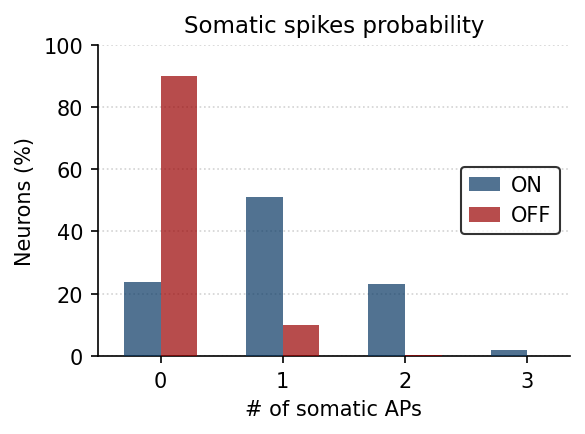

In [11]:
# @title Plot somatic APs probability distribution (dSpikes ON/OFF)
count_soma_ON = b.unique(spikes_ON, return_counts=True)
bins_soma_ON = max(count_soma_ON[0])
count_soma_OFF = b.unique(spikes_OFF, return_counts=True)
bins_soma_OFF = max(count_soma_OFF[0])
width = 0.3
fig, ax = b.subplots(figsize=[4,3])
ax.set_title("Somatic spikes probability")
ax.bar(count_soma_ON[0], count_soma_ON[1]/N_PYR*100, linewidth=0,
       width=width, color='#073763', label='ON', zorder=3, alpha=.7,
        antialiased=True)
ax.bar((count_soma_OFF[0])+width, count_soma_OFF[1]/N_PYR*100, linewidth=0,
       width=width, color='#990000', label='OFF', zorder=3, alpha=.7,
       antialiased=True)
ax.set_xlabel("# spikes")
ax.set_ylabel("Probability")
# ax.set_ylim(0, 1)
ax.set_xlabel("# of somatic APs")
ax.set_ylabel("Neurons (%)")
ax.legend(frameon=True, loc='center right')
ax.set_xticks(count_soma_ON[0] + width/2)
ax.set_xticklabels([str(i) for i in count_soma_ON[0]])
ax.set_yticks(b.arange(0, 120, 20))
ax.set_xlim(right=3.5)
ax.yaxis.grid(zorder=0)
fig.tight_layout()

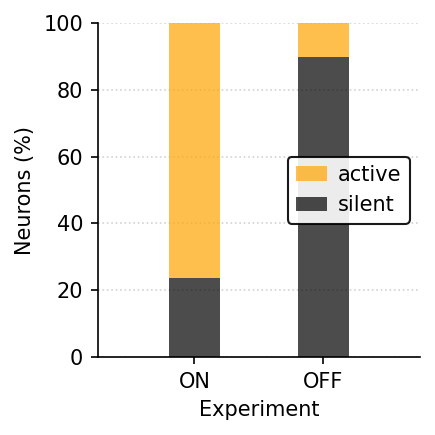

In [12]:
# @title Plot active vs silent (dSpikes ON/OFF)
control_silent = count_soma_ON[1][0]
control_active = sum(count_soma_ON[1][1:])
ttx_silent = count_soma_OFF[1][0]
ttx_active = sum(count_soma_OFF[1][1:])
x = [0, 1]
y1 = [control_silent/100, ttx_silent/100]
y2 = [control_active/100, ttx_active/100]
fig, ax = b.subplots(figsize=[3,3])
ax.bar(x, y2, bottom=y1, color='orange',
        label='active', width=0.4, zorder=3, alpha=.7, antialiased=True,
        rasterized=True)
ax.bar(x, y1, color='black', label='silent', width=0.4, zorder=3, alpha=.7,
        antialiased=True, rasterized=True)
ax.set_ylabel("Neurons (%)")
ax.set_xlabel("Experiment")
ax.legend(ncol=1, loc="center right", framealpha=.9)
ax.set_yticks(b.arange(0, 120, 20))
ax.set_xticks([0, 1])
ax.set_xticklabels(['ON', 'OFF'])
ax.set_ylim(top=100)
ax.set_xlim(left=-0.75, right=1.75)
ax.yaxis.grid(zorder=0)
fig.tight_layout()

## Panels d-f | Parametric exploration

In [13]:
# @title Preprocess data from 242 simulations
# Unzip data
with ZipFile("other/fig7-data.zip", mode="r") as archive:
    archive.extractall("other/pickles")
# Load and curate data
path = "other/pickles/fig7-data"
ec_freqs = b.arange(0.5, 1.6, 0.1)*82
ca3_freqs = b.arange(0.5, 1.6, 0.1)*120
N_pyr = 10000
M1 = b.zeros((11, 11))
M2 = b.zeros((11, 11))
for ix, x in enumerate(ec_freqs):
    for iy, y in enumerate(ca3_freqs):
        file1 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=True FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
        file2 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=False FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
        with open(f"{path}/{file1}", 'rb') as f1, open(f"{path}/{file2}", 'rb') as f2:
            data1, data2 = p.load(f1), p.load(f2)
        spiketimes1 = data1['spiketimes']
        len_spikes1 = b.array([len(spiketimes1[neuron]) for neuron in spiketimes1])
        freqs1 = len_spikes1/(500*ms)
        mean_freq1 = b.mean(freqs1)
        M1[ix][iy] = mean_freq1
        spiketimes2 = data2['spiketimes']
        len_spikes2 = b.array([len(spiketimes2[neuron]) for neuron in spiketimes2])
        freqs2 = len_spikes2/(500*ms)
        mean_freq2 = b.mean(freqs2)
        M2[ix][iy] = mean_freq2

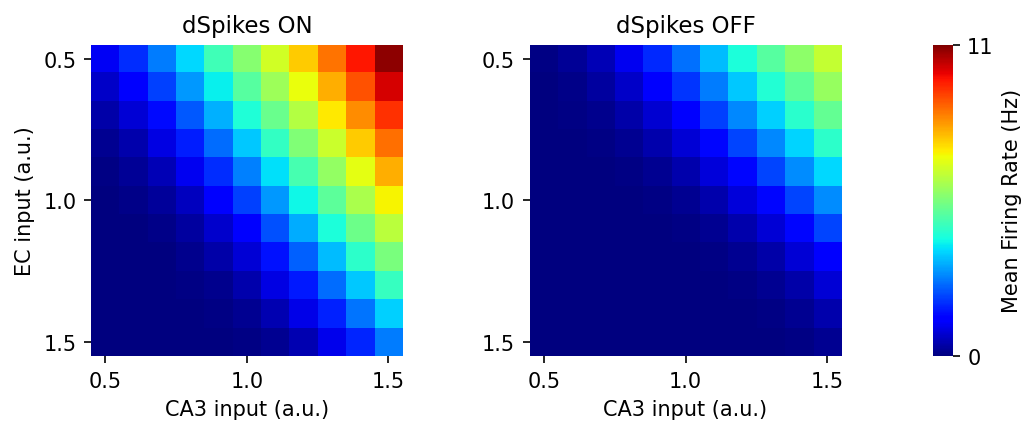

In [14]:
# @title Plot mean network firing rates
ticks = [0, 5, 10] 
tick_labels = ["0.5", "1.0", "1.5"]
fig, axes = b.subplots(ncols=3,figsize=(7.2,3),
                       gridspec_kw={"width_ratios":[1,1, 0.05]})
ax0, ax1, ax2 = axes
h1 = ax0.imshow(b.flipud(M1), vmin=0, vmax=11, cmap='jet')
h2 = ax1.imshow(b.flipud(M2), vmin=0, vmax=11, cmap='jet')
cb = fig.colorbar(h1, cax=ax2, ticks=[0,11], label='Mean Firing Rate (Hz)')
for ax in ax0, ax1:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
ax0.set_title("dSpikes ON")
ax0.set_ylabel("EC input (a.u.)")
ax0.set_xlabel("CA3 input (a.u.)")
ax1.set_title("dSpikes OFF")
ax1.set_xlabel("CA3 input (a.u.)")
cb.outline.set_visible(False)
fig.tight_layout()

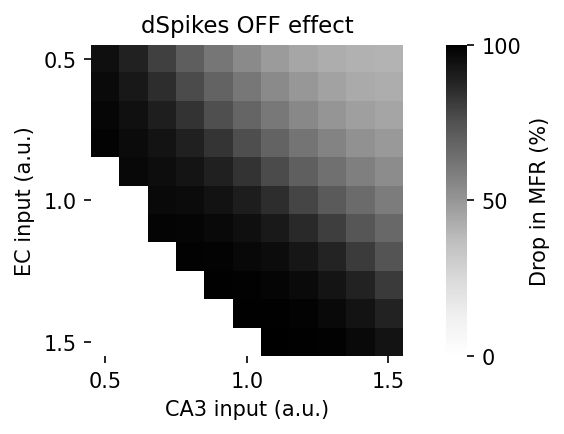

In [15]:
# @title Plot dSpikes OFF effect
M1clean = b.where(M1 > 0.1, M1, -1)
M2clean = b.where(M1 > 0.1, M2, -1)
Mdclean = (M1clean-M2clean) / M1clean
ticks = [0, 5, 10] 
tick_labels = ["0.5", "1.0", "1.5"]
fig, axes = b.subplots(ncols=2,figsize=(4,3),gridspec_kw={
                       "width_ratios":[1,0.05]})
ax0, ax1, = axes
h = ax0.imshow(b.flipud(Mdclean)*100, vmin=0, vmax=100, cmap='Greys')
cb = fig.colorbar(h, cax=ax1, ticks=[0, 50, 100], label="Drop in MFR (%)")
ax0.set_xticks(ticks)
ax0.set_yticks(ticks)
ax0.set_xticklabels(tick_labels)
ax0.set_yticklabels(tick_labels)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.set_ylabel("EC input (a.u.)")
ax0.set_xlabel("CA3 input (a.u.)")
ax0.set_title("dSpikes OFF effect")
cb.outline.set_visible(False)
fig.tight_layout()

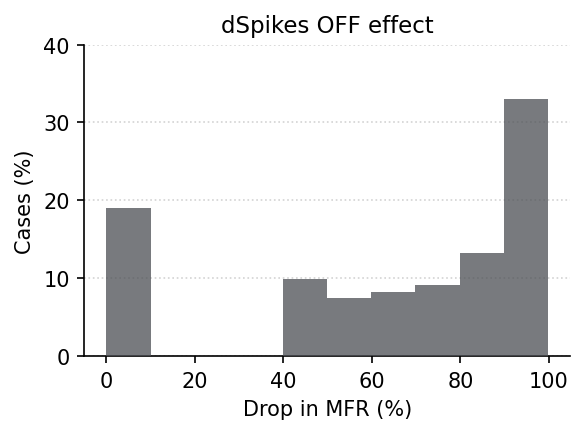

In [16]:
# @title Plot distribution 
fig, ax = b.subplots(figsize=(4,3))
ax.hist(Mdclean.flatten()*100, bins=10, color="#4B4E53",
         zorder=3, alpha=.75, antialiased=True, rasterized=True)
ytickpos = b.arange(0, 50, 10)
ax.set_yticks(b.array(ytickpos*1.21))
ax.set_yticklabels(ytickpos)
ax.set_xlabel("Drop in MFR (%)")
ax.set_ylabel("Cases (%)")
ax.set_xticks(range(0, 120, 20))
ax.yaxis.grid(zorder=0)
ax.set_title("dSpikes OFF effect")
fig.tight_layout()

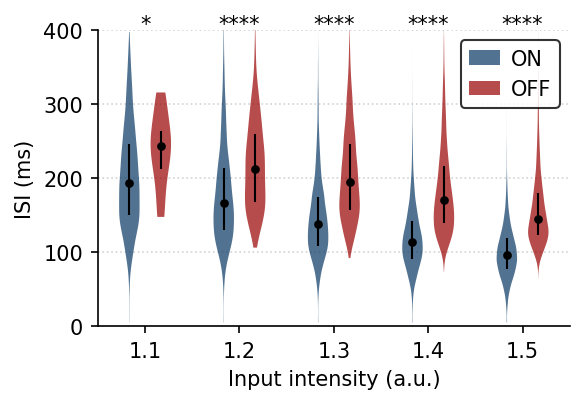

In [17]:
# @title Violin plots
import warnings
warnings.filterwarnings("ignore")
path = "other/pickles/fig7-data"
ec_freqs = b.arange(1, 1.5, 0.1)*82
ca3_freqs = b.arange(1, 1.5, 0.1)*120
data_ON = []
data_OFF = []
for x, y in zip(ec_freqs, ca3_freqs):
    file1 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=True FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
    file2 = f"INPUT_EC=True INPUT_CA3=True DSPIKES=False FREQ_EC={x:.1f}Hz FREQ_CA3={y:.1f}Hz N_PYR=10000 T_SIM=500ms.pkl"
    with open(f"{path}/{file1}", 'rb') as f1, open(f"{path}/{file2}", 'rb') as f2:
        data1, data2 = p.load(f1), p.load(f2)
    spiketimes1 = data1['spiketimes']
    oneplus1 = [spiketimes1[neuron]
                for neuron in spiketimes1 if
                len(spiketimes1[neuron]) >= 2]
    isi1 = [(b.diff(spikes)/ms) for spikes in oneplus1]
    isi1_flat = b.hstack(isi1)
    data_ON.append(isi1_flat)
    spiketimes2 = data2['spiketimes']
    oneplus2 = [spiketimes2[neuron]
                for neuron in spiketimes2 if
                len(spiketimes2[neuron]) >= 2]
    isi2 = [(b.diff(spikes)/ms) for spikes in oneplus2]
    isi2_flat = b.hstack(isi2)
    data_OFF.append(isi2_flat)
fig, ax = b.subplots(figsize=[4,2.8])
violin1 = ax.violinplot(data_ON, positions=[0, 3, 6, 9, 12],
                        showextrema=False, widths=.65)
violin2 = ax.violinplot(data_OFF, positions=[1, 4, 7, 10, 13],
                        showextrema=False, widths=.65)
for vp1, vp2 in zip(violin1['bodies'],  violin2['bodies']):
    vp1.set_facecolor('#073763')
    vp1.set_zorder(2)
    vp1.set_alpha(0.7)
    vp2.set_facecolor('#990000')
    vp2.set_zorder(2)
    vp2.set_alpha(0.7)
medians = []
quartile1 = []
quartile3 = []
for i in data_OFF:
    q1, median, q3 = b.percentile(i, [25, 50, 75], axis=0)
    medians.append(median)
    quartile1.append(q1)
    quartile3.append(q3)
inds = [1, 4, 7, 10, 13]
ax.scatter(inds, medians, marker='o', color='black', s=10, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=1)
medians = []
quartile1 = []
quartile3 = []
for i in data_ON:
    q1, median, q3 = b.percentile(i, [25, 50, 75], axis=0)
    medians.append(median)
    quartile1.append(q1)
    quartile3.append(q3)
inds = [0, 3, 6, 9, 12]
ax.scatter(inds, medians, marker='o', color='black', s=10, zorder=3)
ax.vlines(inds, quartile1, quartile3, color='black', linestyle='-', lw=1)
for pos, stars in zip([0.5, 3.5, 6.5, 9.5, 12.5],
                     ['*', "****", "****", "****", "****"]):
    ax.text(pos, 400, stars, ha='center')
handles = [mpatches.Patch(edgecolor=None, facecolor='#073763', alpha=.7),
           mpatches.Patch(edgecolor=None, facecolor='#990000', alpha=.7)]
labels = ['ON', 'OFF']
ax.legend(handles, labels, loc='upper right', ncol=1)
ax.yaxis.grid(zorder=0)
ax.set_ylabel("ISI (ms)")
ax.set_xlabel("Input intensity (a.u.)")
ax.set_ylim(top=400, bottom=0)
ax.set_xticks(b.arange(0, 15, 3)+.5)
ax.set_xticklabels([1.1, 1.2, 1.3, 1.4, 1.5])
fig.tight_layout()

In [18]:
# @title Statistical tests for violin plots
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
print("Perform independent t-tests: \n")
pvals = []
for on, off in zip(data_ON, data_OFF):
    ttest = stats.ttest_ind(on, off)
    _, p = ttest
    pvals.append(p)
    print(ttest)
_, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05)
print("\n\nCorrected p values for multiple tests: \n")
print(pvals_corrected)

Perform independent t-tests: 

Ttest_indResult(statistic=-2.156879000077473, pvalue=0.031102035056094435)
Ttest_indResult(statistic=-12.178693698397145, pvalue=7.117316596669961e-34)
Ttest_indResult(statistic=-53.05617060593662, pvalue=0.0)
Ttest_indResult(statistic=-108.92480049283358, pvalue=0.0)
Ttest_indResult(statistic=-150.48935985109054, pvalue=0.0)


Corrected p values for multiple tests: 

[3.11020351e-02 1.42346332e-33 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


## Bonus | Running simulations in parallel

> *Using the the script shown bellow, we run multiple simulations with different parameters in parallel. 242 simulations of 10.000 neurons each (duration = 500 ms, dt = 0.1ms) required ~25 minutes to run in a laptop with an Intel i7-9750h CPU and 16 GB of RAM, using only 6 of the 12 available threads.*

```
import os
from numpy import arange
from time import time
from multiprocessing import Pool

#### Define functions #########################################################
freq_range = arange(0.5, 1.6, 0.1, dtype=float)
def sim_params():
    """Specify all combinations of simulation paramaters"""
    params = []
    for input_ec in [True]:
        for input_ca3 in [True]:
            for dspikes in [True, False]:
                for freq_ec in freq_range*82:
                    for freq_ca3 in freq_range*120:
                        _params = ' '.join(
                            [f'INPUT_EC={input_ec}',
                             f'INPUT_CA3={input_ca3}',
                             f'DSPIKES={dspikes}',
                             f'FREQ_EC={freq_ec:.1f}*Hz',
                             f'FREQ_CA3={freq_ca3:.1f}*Hz',
                             'N_PYR=10000',
                             'T_SIM=500*ms'])
                        params.append(_params)
    return params


def run_process(process):
    """os call to run a single simulation"""
    os.system(f'python {process}')


def submit_processes(scriptname=None, args=None, threads=1):
    to_submit = [f'{scriptname} {arg}' for arg in args]
    pool = Pool(processes=threads)
    pool.map(run_process, to_submit)


#### Submit jobs ##############################################################
t_start = time()
script = 'fig_coincidence_panels.py'
cmd_params = sim_params()
n_threads = 6
print(f'NUMBER OF SIMULATIONS: {len(cmd_params)}')
print(f'MAX NUMBER OF THREADS: {n_threads}\n')
submit_processes(scriptname=script, args=cmd_params, threads=n_threads)
t_end = time()
print(f"\nOverall time: {t_end-t_start:.2f} s")
```

> *To convert the command line arguments into simulation properties we also include the following piece of code in the beggining of the simulation file (right after the imports):*

```
params_list = []
for i in sys.argv[1:]:
    var, value = i.split('=')
    exec(f"{var} = {value}")
    params_list.append(f"{var}={value}")
    params = ' '.join(params_list)
```

